# Trying FGSM attack on our fasterRCNN model

In [17]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor #load the roi head with defined num of classes

from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

#For the attack
from art.attacks.evasion import FastGradientMethod
from art.estimators.object_detection import PyTorchFasterRCNN

DEVICE = torch.device('cpu')

In [18]:
KITTI_INSTANCE_CATEGORY_NAMES = {0: u'Cyclist', 1: u'DontCare', 2: u'Misc', 3: u'Person_sitting', 4: u'Tram', 5: u'Truck', 6: 'Van', 7: u'car', 8: u'person'}
NUM_CLASSES=len(KITTI_INSTANCE_CATEGORY_NAMES)

In [19]:
#load model's architecture
model=torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
#load pretrained model
checkpoint = torch.load("/home/aya/Desktop/Kitti_FasterRCNN/outputs/training/resultat/best_model.pth", map_location=DEVICE)


# Get the number of input features 
in_features = model.roi_heads.box_predictor.cls_score.in_features

# define a new head for the detector with required number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [20]:
#seperate the 3 keys (boxes, labels, scores)
def DrawBbox(image,pred,thresh=0.5,txt_color=(255, 255, 255)):
  
  origin_im=image.copy()

  #seperate the 3 keys (boxes, labels, scores)
  bboxes, labels, scores= pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]

  #define a threshold score
  score=torch.argwhere(scores>=thresh)
  
  print("number of objects with {} confidence: {}".format(thresh, score.shape[0]))

  #Define a set of colors for the bboxes
  colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]
  for i in range(bboxes.shape[0]):
    if scores.numpy()[i-1]>=thresh:
      x1, y1, x2, y2= bboxes[i-1].numpy().astype("int") #convert the list to a numpy array of ints 
      #label+score
      class_name=KITTI_INSTANCE_CATEGORY_NAMES[labels.numpy()[i-1]]+ str(round(scores.numpy()[i-1]*100))+"%" #i-1 because lists indexes start by zero

      
      lw = max(round(sum(origin_im.shape) / 2 * 0.003), 2)# costumize thickness
      #print the bbox on the image
      image=cv2.rectangle(origin_im, (x1,y1), (x2,y2), colors[i], thickness=lw)


      tf = max(lw - 1, 1)  # font thickness
      w, h = cv2.getTextSize(class_name, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
      outside = y1 - h >= 3
      p2 = (x1 + w, y1 - h - 3 if outside else y1 + h + 3)
      
      #print the labels next to the bbox
      image=cv2.rectangle(origin_im, (x1,y1), p2, colors[i], -1, cv2.LINE_AA)
      image=cv2.putText(origin_im,class_name,(x1, y1- 2 if outside else y1 + h + 2), 0, lw / 3 ,txt_color, 2, cv2.LINE_AA)

  plt.figure(figsize=(15,15))
  plt.axis("off")
  plt.imshow(image.astype(np.uint8), interpolation="nearest")

In [21]:
input_img=cv2.imread("/home/aya/Desktop/Kitti_FasterRCNN/data/test/images/000833.png")
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) # Convert to RGB
#convert the PIL image to a tensor because model(img) accept a tensor image
ConvertTensor=transforms.ToTensor()
tensor_img = ConvertTensor(input_img)

In [22]:
import time
# Use the model for inference
#pass the image to the model
start_time = time.time()
with torch.no_grad(): #not to use the gradient function of pytorch (grad will not be calculated)
    pred=model([tensor_img],)
end_time = time.time()

number of objects with 0.6 confidence: 10


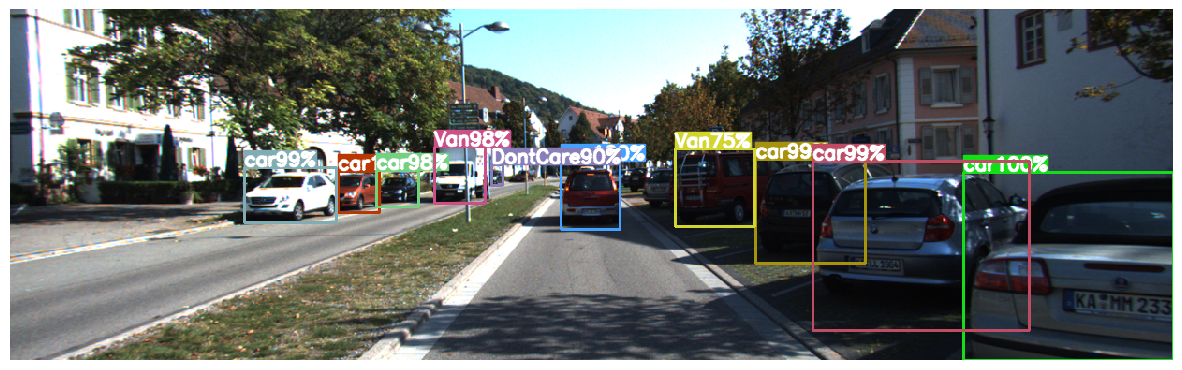

In [23]:
#Draw bboxes
DrawBbox(input_img,pred,0.6)

In [24]:
# bboxes, labels, scores = pred[0]["boxes"], pred[0]["labels"], pred[0]["scores"]
# for j in range(0, bboxes.shape[0]):
#             # (xmin,ymin)=top left and (xmax,ymax)= bottom right
#             xmin, ymin, xmax, ymax = bboxes[j].numpy().astype("int")
#             print(KITTI_INSTANCE_CATEGORY_NAMES[int(labels[j])])
#             print("xmin:",xmin)
#             print("xmax:",xmax)
#             print("ymin:",ymin)
#             print("ymax:",ymax)

## Generate an Adversarial Attack

In [25]:
# Create ART object detector
frcnn = PyTorchFasterRCNN(model,
        clip_values=(0, 255), attack_losses=["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"],device_type="cpu"
    )

In [26]:
#img = cv2.resize(input_img, dsize=(img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC) #resize if you have more than one image (in order to stack them)
# Stack images
image = np.stack([input_img], axis=0).astype(np.float32)
print("image.shape:", image.shape)


image.shape: (1, 375, 1242, 3)


In [27]:
pred[0]["boxes"].numpy().astype(np.float32)

array([[ 588.9819   ,  162.40744  ,  651.03064  ,  235.5438   ],
       [1018.7909   ,  174.45737  , 1242.       ,  375.       ],
       [ 350.1152   ,  173.08531  ,  394.83054  ,  217.55225  ],
       [ 796.5119   ,  160.38959  ,  913.72955  ,  271.10443  ],
       [ 857.4763   ,  162.18094  , 1088.7318   ,  343.99408  ],
       [ 250.04848  ,  169.05022  ,  348.80386  ,  228.71103  ],
       [ 391.36243  ,  172.42584  ,  436.71603  ,  211.14502  ],
       [ 453.50546  ,  147.12268  ,  507.1607   ,  207.61911  ],
       [ 514.2757   ,  166.2689   ,  526.9301   ,  188.76701  ],
       [ 710.45557  ,  149.41756  ,  795.44836  ,  232.31982  ],
       [ 715.32117  ,  147.56653  ,  813.76544  ,  233.29176  ],
       [1239.5013   ,    0.       , 1241.9797   ,   10.065593 ],
       [ 566.3855   ,  162.84328  ,  584.2979   ,  183.78903  ],
       [ 393.72067  ,  169.36578  ,  437.0968   ,  211.56729  ],
       [ 449.09067  ,  153.80615  ,  511.4167   ,  204.33276  ],
       [ 249.25423  ,  16

In [28]:
y_target=pred.copy()
for i in range(len(y_target[0]["labels"])):
       if(y_target[0]["labels"][i]==7):
              y_target[0]["labels"][i]=3

In [29]:
# Create and run attack
epsilon = 15
attack = FastGradientMethod(estimator=frcnn, eps=epsilon, eps_step=0.3, max_iter=5,targeted=True,summary_writer=True)
#attack = BoundaryAttack(estimator=frcnn, targeted=False, max_iter=100, epsilon=0.01)
image_adv = attack.generate(x=image, y=y_target) #Target labels `y` need to be provided for a targeted attack

print("\nThe attack budget eps is {}".format(epsilon))
print("The resulting maximal difference in pixel values is {}.".format(np.amax(np.abs(input_img - image_adv))))

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]


The attack budget eps is 15
The resulting maximal difference in pixel values is 14.400146484375.


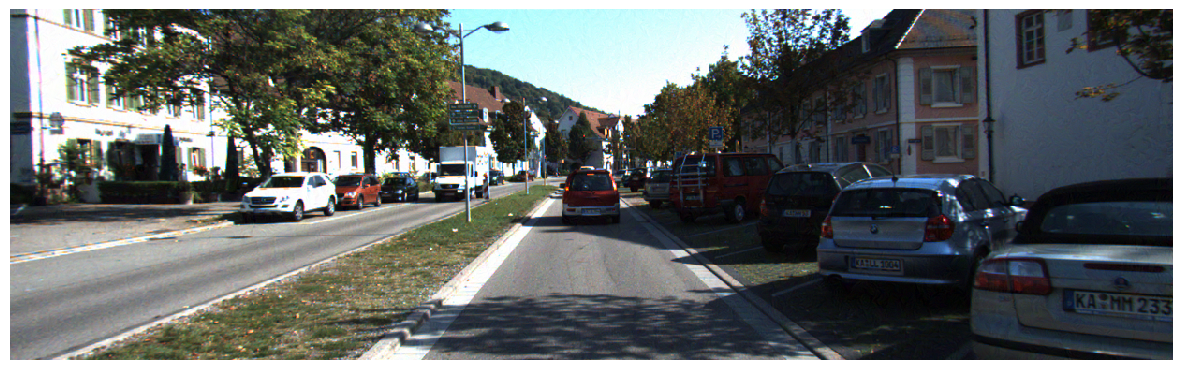

In [30]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(image_adv[0].astype(np.uint8), interpolation="nearest")

In [31]:
# save the image
img=image_adv[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite("photo.png", img)

True

In [32]:
img=Image.open("photo.png")
#convert the PIL image to a tensor
ConvertTensor=transforms.ToTensor()
img = ConvertTensor(img)

model.eval()
#predict
with torch.no_grad(): #not to use the gradient function of pytorch (grad will not be calculated)
    pred=model([img],)
end_time = time.time()

number of objects with 0.5 confidence: 46


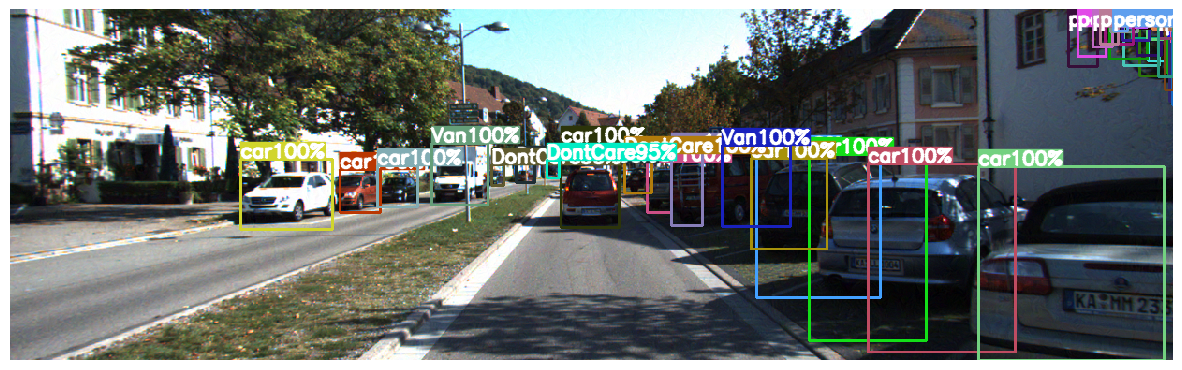

In [33]:
#read the image in cv2
im=cv2.imread("photo.png")
# Convert to RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#Draw bboxes
DrawBbox(im,pred,0.5)